In [1]:
import gym
import universe

import os

In [2]:
import math

import time
import random
import pickle

from collections import deque

%matplotlib notebook
import matplotlib as mpl
plt = mpl.pyplot
# mpl.pylab.rcParams['figure.figsize'] = (12, 9)

import numpy as np
import torch as tch
F = tch.nn.functional

In [3]:
tch.cuda.is_available()

True

In [4]:
# pytorch auxiliar functions
def np2var(input):
    output = tch.autograd.Variable(tch.from_numpy(input), volatile=True)
    if tch.cuda.is_available():
        output = output.cuda()
    return output

# tanh2sigmoid = lambda x: (x + 1) / 2

def postprocess(tch_img):
    return (tch_img * 255).int().data.cpu().numpy().squeeze()

# screen slicing00
top = 86
left = 20 + 100
height = 300
width = 500 - 200
gamescreen_slice = (slice(top,  top + height), slice(left, left + width))
game_center = (top + height // 2, left + width // 2) # y, x
game_center = game_center[::-1]

# average pooling for downscaling
s = downscale_size = 2
pool2d_downscale = tch.nn.AvgPool2d((s, s), stride=(s, s))
downscale_n = 1
downscale = downscale_size ** downscale_n
dummy_img = np.zeros((height // downscale, width // downscale, 1))

action_size = 3

In [5]:
class FCN(tch.nn.Module):
    def __init__(self, sizes, act=F.selu, output_act=None):
        super(FCN, self).__init__()
        self.sizes = tuple(sizes)
        self.act = act
        if output_act:
            self.output_act = output_act
        else:
            self.output_act = lambda x: x

        self.layers = tch.nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.layers.append(tch.nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, input):
        for layer in list(self.layers)[:-1]:
           input = self.act(layer(input))
        output = self.output_act(self.layers[-1](input))

        return output

action_code_size = 16

action_encoder = FCN([action_size, 128, 128, action_code_size], act=F.selu, output_act=F.selu)

if tch.cuda.is_available():
    action_encoder = action_encoder.cuda()

class CNN_encoder(tch.nn.Module):
    def __init__(self, n_convs=5, out_ch=128, act=F.selu):
        
        super(CNN_encoder, self).__init__()
        
        self.n_convs = n_convs
        self.kernel_size = (4, 4)
        self.out_ch = out_ch
        self.act = act
        
        self.conv_layers = tch.nn.ModuleList()
        self.conv_layers.append(tch.nn.Conv2d(1, 16, self.kernel_size, stride=(2, 2), padding=(2, 2)))
        self.conv_layers.append(tch.nn.Conv2d(16, 16, self.kernel_size, stride=(2, 2), padding=(1, 1)))
        self.conv_layers.append(tch.nn.Conv2d(16, 32, self.kernel_size, stride=(2, 2), padding=(2, 2)))
        self.conv_layers.append(tch.nn.Conv2d(32, 64, self.kernel_size, stride=(2, 2), padding=(1, 1)))
        self.conv_layers.append(tch.nn.Conv2d(64, 128, self.kernel_size, stride=(2, 2), padding=(1, 1)))
        self.conv_layers.append(tch.nn.Conv2d(128, 512, (5, 5), stride=(1, 1), padding=(0, 0)))
            
        self.last_conv_unrolled_size = 512
        self.fc_sizes = []
        self.fc_layers = tch.nn.ModuleList()
        in_size = self.last_conv_unrolled_size
        for out_size in self.fc_sizes:
            self.fc_layers.append(tch.nn.Linear(in_size, out_size))
            in_size = out_size
            
        self.conv_sizes = []
            
    def forward(self, input):
        
        self.conv_sizes = []

        output = input
        for layer in list(self.conv_layers):
            self.conv_sizes.append(tuple(output.size()))
            output = self.act(layer(output))
        self.conv_sizes.append(tuple(output.size()))
        
        output = output.view(-1, self.last_conv_unrolled_size)
        
        for layer in self.fc_layers:
            output = self.act(layer(output))
        
        return output

encoder = CNN_encoder()

for param in encoder.parameters():
    n = np.prod(list(param.size())[-3:]) # valid for 2D convolutions
    stdv = 2. / math.sqrt(n)
    param.data.uniform_(-stdv, stdv)

if tch.cuda.is_available():
    encoder = encoder.cuda()

dummy_img_T = dummy_img.transpose(2, 0, 1)
dummy_img_T = np2var(dummy_img_T).float().unsqueeze(0)
_ = encoder(dummy_img_T)

In [6]:
class CNN_decoder(tch.nn.Module):
    def __init__(self, encoder):
        
        super(CNN_decoder, self).__init__()
        
        self.act = encoder.act
        
        self.input_size = encoder.fc_sizes[-1] if len(encoder.fc_sizes) > 0 else None
        self.fc_sizes = (encoder.fc_sizes[-2::-1] + [encoder.last_conv_unrolled_size] 
                         if len(encoder.fc_sizes) > 0 else [])
        
        self.last_conv_shape = (-1, ) + encoder.conv_sizes[-1][1:]
        
        self.fc_layers = tch.nn.ModuleList()

        in_size = self.input_size
        for out_size in self.fc_sizes:
            self.fc_layers.append(tch.nn.Linear(in_size, out_size))
            in_size = out_size
            
            
        self.convtrans_layers = tch.nn.ModuleList()
        in_ch = encoder.conv_sizes[-1][1]
        for output_shape, encode_layer in zip(encoder.conv_sizes[-2::-1], tuple(encoder.conv_layers)[::-1]):
            out_ch = output_shape[1]
            self.convtrans_layers.append(tch.nn.ConvTranspose2d(in_ch, out_ch,
                                                                encode_layer.kernel_size,
                                                                encode_layer.stride,
                                                                encode_layer.padding))
            in_ch = out_ch
            
        
    def forward(self, input):
        
        output = input
        for layer in self.fc_layers:
            output = self.act(layer(output))
            
        output = output.view(*self.last_conv_shape)
        
        for layer in list(self.convtrans_layers)[:-1]:
            output = self.act(layer(output))   
        output = F.sigmoid(self.convtrans_layers[-1](output))
        
        return output
        

decoder = CNN_decoder(encoder)

for param in decoder.parameters():
    n = 1 if len(param.size()) == 1 else param.size()[0]
    n *= np.prod(list(param.size())[-2:]) # valid for 2D convolutions
    stdv = 2. / math.sqrt(n)
    param.data.uniform_(-stdv, stdv)

if tch.cuda.is_available():
    decoder = decoder.cuda()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class customLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, num_variants):
        super(customLSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_variants = num_variants
        
        self.ih = nn.Linear(self.input_size, 4 * self.hidden_size * self.num_variants)
        self.hh = nn.Linear(self.hidden_size, 4 * self.hidden_size * self.num_variants)
        
        self.hhh = nn.Linear(self.hidden_size, self.num_variants)
        
    def forward(self, input, hidden):
        
        hx, cx = hidden
        
        gates = self.ih(input) + self.hh(hx)
        
        gates_weights = F.softmax(self.hhh(cx))
        record.append(gates_weights)
        gates = gates.view(-1, 4 * self.hidden_size, self.num_variants)
        gates = torch.matmul(gates, gates_weights.squeeze())        
        
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        
        ingate = F.sigmoid(ingate)
        forgetgate = F.sigmoid(forgetgate)
        cellgate = F.tanh(cellgate)
        outgate = F.sigmoid(outgate)
        
        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * F.tanh(cy)

        return hy, cy

    
class LSTM_predictor(tch.nn.Module):
    
    def __init__(self, size, hidden_size):
        
        super(LSTM_predictor, self).__init__()
        
        self.cell = customLSTMCell(size, hidden_size, 8)
        
        self.output_layer = tch.nn.Linear(hidden_size, size)
        
        self.act = encoder.act
        
    def forward(self, hidden, input):
               
        hidden = self.cell(input, hidden)
        
        output = self.act(self.output_layer(hidden[0]))
        
        return hidden, output
        
    def zero_hidden(self):
        
        hidden = (tch.autograd.Variable(tch.zeros(1, self.cell.hidden_size)),
                  tch.autograd.Variable(tch.zeros(1, self.cell.hidden_size)))
        
        if tch.cuda.is_available():
            hidden = tuple(h.cuda() for h in hidden)
            
        return hidden # h_0, c_0
    
predictor = LSTM_predictor(512, 512)

if tch.cuda.is_available():
    predictor = predictor.cuda()

In [7]:
class LSTM_predictor(tch.nn.Module):
    
    def __init__(self, input_size, output_size, hidden_size):
        
        super(LSTM_predictor, self).__init__()
        
        self.cell = tch.nn.LSTMCell(input_size, hidden_size)
        
        self.output_layer = tch.nn.Linear(hidden_size, output_size)
        
        self.act = encoder.act
        
    def forward(self, hidden, input):
               
        hidden = self.cell(input, hidden)
        
        output = self.act(self.output_layer(hidden[0]))
        
        return hidden, output
        
    def zero_hidden(self):
        
        hidden = (tch.autograd.Variable(tch.zeros(1, self.cell.hidden_size)),
                  tch.autograd.Variable(tch.zeros(1, self.cell.hidden_size)))
        
        if tch.cuda.is_available():
            hidden = tuple(h.cuda() for h in hidden)
            
        return hidden # h_0, c_0
    
predictor = LSTM_predictor(512 + action_code_size, 512, 512)

if tch.cuda.is_available():
    predictor = predictor.cuda()

In [8]:
class dummy_module(tch.nn.Module):

    def __init__(self, encoder, decoder, predictor, action_encoder):
        super(dummy_module, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.predictor = predictor
        self.action_encoder = action_encoder

    def forward(self):
        pass

dummy = dummy_module(encoder, decoder, predictor, action_encoder)

In [9]:
load_id = 'slither-AE-LSTM-final-act-e2e-sim'
# load_id = 'slither-AE-LSTM-final-act-e2e'

tch.save(dummy.cpu().state_dict(), load_id+'-dict-dummy')

In [10]:
dummy.cpu().load_state_dict(tch.load(load_id+'-dict-dummy'))
dummy = dummy.cuda()

plt.figure()
plt.plot(torch.cat(record).data.cpu().numpy())

<IPython.core.display.Javascript object>


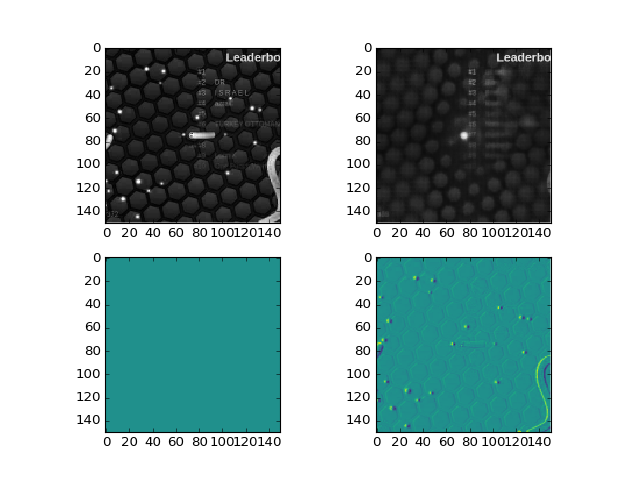

In [11]:
# visualization
fig, axes = mpl.pyplot.subplots(2, 2)

# initialization of visualization
imgs = [ax.imshow(dummy_img.squeeze(), interpolation='none', vmin=0, vmax=255, cmap='gray') for ax in axes[0]]
imgs.extend(ax.imshow(dummy_img.squeeze(), interpolation='none', vmin=-255, vmax=255, cmap='viridis') for ax in axes[1])


# fig_loss, ax_loss = plt.subplots()

In [13]:
# load_id = 'slither-AE-LSTM-final-act-e2e'
load_id = 'slither-AE-LSTM-final-act-e2e-sim'

# history = pickle.load(open(load_id, "rb"))
action_encoder_load = tch.load(load_id + 'action_encoder.pkl')
encoder_load = tch.load(load_id + 'encoder.pkl')

decoder_load = tch.load(load_id + 'decoder.pkl')
predictor_load = tch.load(load_id + 'predictor.pkl')

for module, module_load in zip((action_encoder, encoder, decoder, predictor), (action_encoder, encoder_load, decoder_load, predictor_load)):
    for param, param_load in zip(module.parameters(), module_load.parameters()):
        param.data = param_load.data

# start = time.time()
# assert decoder(encoder(dummy_img_T)).size() == dummy_img_T.size()
# assert decoder(predictor(predictor.zero_hidden(), encoder(dummy_img_T))[1]).size() == dummy_img_T.size()
# # fig.canvas.draw()
# end = time.time()

# end - start

# history = pickle.load(open(load_id, "rb"))
# h = np.asarray(history)

# window = 100
# ax_loss.cla()
# ax_loss.plot(np.convolve(h, np.ones(window)/window, mode='valid'))
# ax_loss.plot(np.convolve(h[:, 0], np.ones(window)/window, mode='valid'))
# ax_loss.plot(np.convolve(h[:, 1], np.ones(window)/window, mode='valid'))
# ax_loss.plot(np.convolve(h[:, 1] / h[:, 0], np.ones(window)/window, mode='valid'))

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

# Standard

In [12]:
hidden = predictor.zero_hidden()

while True:
    
    with open('./game_dataset_action/' + random.choice(os.listdir('./game_dataset_action/')), 'rb') as gamescreen_file:
        print(gamescreen_file)
#     with open('./game_dataset/276.pickle', 'rb') as gamescreen_file:
#     with open('./game_dataset/89.pickle', 'rb') as gamescreen_file:
              
        gamescreen_list = pickle.load(gamescreen_file)
        decoded_gamescreen = None
        
        for action, gamescreen, _ in gamescreen_list:
            
#             gamescreen = gamescreen if decoded_gamescreen is None else decoded_gamescreen
            gamescreen = np2var(gamescreen).float() / 255
            gamescreen = gamescreen.unsqueeze(0).unsqueeze(0)
            action = np2var(action).unsqueeze(0)

            # compute
            action_code = action_encoder(action)
            gs_code = encoder(gamescreen)
            decoded_gamescreen = decoder(gs_code)
            code = tch.cat((gs_code, action_code), dim=-1)
            hidden, pred_code = predictor(hidden, code)
            decoded_pred_gamescreen = decoder(pred_code)
              
            # display
            gamescreen = postprocess(gamescreen)
            decoded_gamescreen = postprocess(decoded_gamescreen)
            decoded_pred_gamescreen = postprocess(decoded_pred_gamescreen)
            imgs[0].set_data(gamescreen)
#             imgs[1].set_data(decoded_gamescreen)
            imgs[1].set_data(decoded_pred_gamescreen)
            fig.canvas.draw()
#             time.sleep(2.0)

        hidden = predictor.zero_hidden()

<_io.BufferedReader name='./game_dataset_action/482.pickle'>
<_io.BufferedReader name='./game_dataset_action/348.pickle'>
<_io.BufferedReader name='./game_dataset_action/417.pickle'>


KeyboardInterrupt: 

# Final

In [13]:
hidden = predictor.zero_hidden()

while True:
    
    with open('./game_dataset_action/' + random.choice(os.listdir('./game_dataset_action/')), 'rb') as gamescreen_file:
        print(gamescreen_file)
#     with open('./game_dataset/276.pickle', 'rb') as gamescreen_file:
#     with open('./game_dataset/89.pickle', 'rb') as gamescreen_file:
              
        gamescreen_list = pickle.load(gamescreen_file)
        prev_pred_gamescreen = None
        prev_gamescreen = None
        
        for idx, (action, gamescreen, _) in enumerate(gamescreen_list):
            
#             gamescreen = gamescreen if decoded_gamescreen is None else decoded_gamescreen
            gamescreen = np2var(gamescreen).float() / 255
            gamescreen = gamescreen.unsqueeze(0).unsqueeze(0)
            action = np2var(action).unsqueeze(0)

            if prev_pred_gamescreen is None:
                prev_pred_gamescreen = 0
                prev_gamescreen = 0
            if idx > 32:
                prev_pred_gamescreen = gamescreen
                action = np2var(np.asarray(((1,0,0),), np.float32))
            # compute
            action_code = action_encoder(action)
            err_gs = prev_pred_gamescreen - gamescreen
            diff_gs = prev_gamescreen - gamescreen
            gs_code = encoder(prev_pred_gamescreen - gamescreen)
            decoded_gamescreen = decoder(gs_code)
            code = tch.cat((gs_code, action_code), dim=-1)
            hidden, pred_code = predictor(hidden, code)
            prev_pred_gamescreen = decoder(pred_code)
            prev_gamescreen = gamescreen
              
            # display
            gamescreen = postprocess(gamescreen)
            err_gamescreen = postprocess(err_gs)
            diff_gamescreen = postprocess(diff_gs)
            decoded_gamescreen = postprocess(decoded_gamescreen)
            decoded_pred_gamescreen = postprocess(prev_pred_gamescreen)
            imgs[0].set_data(gamescreen)
#             imgs[1].set_data(decoded_gamescreen)
            imgs[1].set_data(decoded_pred_gamescreen)
            imgs[2].set_data(err_gamescreen)
            imgs[3].set_data(diff_gamescreen)
            fig.canvas.draw()
#             time.sleep(2.0)

        hidden = predictor.zero_hidden()

<_io.BufferedReader name='./game_dataset_action/323.pickle'>


KeyboardInterrupt: 